<a href="https://colab.research.google.com/github/PiotrMaciejKowalski/BigData2024Project/blob/Analiza-szeregow-czasowych-dot-roslinnosci/colabs/Analiza_szereg%C3%B3w_czasowych_dot_ro%C5%9Blinno%C5%9Bci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wczytywanie danych w sparku

Utworzenie środowiska pyspark do obliczeń:

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"
import findspark
findspark.init()
from pyspark.sql import SparkSession
from google.colab import drive
from pyspark.sql.types import IntegerType, FloatType, StringType, StructType
import pandas as pd

Utowrzenie sesji:

In [5]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

Połączenie z dyskiem:

In [6]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Wczytanie danych NASA znajdujących się na dysku w sparku:

In [7]:
# Wczytanie zbioru sampled w celu pobrania nazw kolumn
sampled = pd.read_csv('/content/drive/MyDrive/BigMess/NASA/sampled_NASA_200k.csv')

# Utworzenie schematu określającego typ zmiennych
schemat = StructType()
for i in sampled.columns:
  if i == "Date":
    schemat = schemat.add(i, StringType(), True)
  else:
    schemat = schemat.add(i, FloatType(), True)

In [8]:
# Wczytanie zbioru Nasa w sparku
nasa = spark.read.format('csv').option("header", True).schema(schemat).load('/content/drive/MyDrive/BigMess/NASA/NASA.csv')

Zanim zacznimy pisać kwerendy należy jeszcze dodać nasz DataFrame (df) do "przestrzeni nazw tabel" Sparka:

In [9]:
nasa.createOrReplaceTempView("nasa")

Rozdzielenie kolumny "Date" na kolumny "Year" oraz "Month"

In [10]:
nasa = spark.sql("""
          SELECT
          CAST(SUBSTRING(CAST(Date AS STRING), 1, 4) AS INT) AS Year,
          CAST(SUBSTRING(CAST(Date AS STRING), 5, 2) AS INT) AS Month,
          n.*
          FROM nasa n
          """)

In [11]:
nasa = nasa.drop("Date")
nasa.createOrReplaceTempView("nasa")

# Analiza szergów czasowych  dot. roślinności

In [104]:
# Import biblotek
import matplotlib.pyplot as plt
import random
import matplotlib.gridspec as gridspec

In [13]:
# Ograniczenie zbioru nasa do wartości, które potrzebujemy, ustawienie pomiaru zawsze na 1 dzień miesiąca
szeregNasa = spark.sql("""
                      SELECT
                      lon, lat,
                      to_date(CONCAT(Year, '-', Month, '-1')) as Date, GVEG, LAI
                      FROM nasa
                      order by lon, lat, Date
                      """)

In [21]:
%%time
szeregNasa.show(5)

+---------+-------+----------+----------+---------+
|      lon|    lat|      Date|      GVEG|      LAI|
+---------+-------+----------+----------+---------+
|-124.9375|48.8125|2000-01-01|0.46137917|5.1595616|
|-124.9375|48.8125|2000-02-01| 0.5240135| 5.282396|
|-124.9375|48.8125|2000-03-01| 0.5501322|5.3335876|
|-124.9375|48.8125|2000-04-01| 0.6215243|5.4735794|
|-124.9375|48.8125|2000-05-01| 0.7106863| 5.648254|
+---------+-------+----------+----------+---------+
only showing top 5 rows

CPU times: user 2.85 ms, sys: 0 ns, total: 2.85 ms
Wall time: 225 ms


In [18]:
# Wyzanczenie unikatowych par współrzednych ze zbioru Nasa i zapisanie w Pandas
%%time
distinct_wsp = spark.sql("""
                          SELECT DISTINCT lon, lat from nasa
                          """).toPandas()

CPU times: user 2.74 s, sys: 244 ms, total: 2.98 s
Wall time: 7min 24s


In [22]:
distinct_wsp.shape

(76360, 2)

In [105]:
# Funkcja generująca wykres w czasie wartości zmiennej GVEG - green vegetation dla zadanych współrzednych
def wykres_szeregu(lon, lat):
  # ograniczenie zbioru do konkretnej pary współrzędnych
  szereg = szeregNasa.filter((szeregNasa['lon'] == lon) & (szeregNasa['lat'] == lat)).drop('lon', 'lat')
  # Przejście na pandas
  szeregPandas = szereg.toPandas()
  # Ustawienie 'date' jako indeksu
  szeregPandas.set_index('Date', inplace=True)
  # Obliczanie 12-miesięcznej średniej kroczącej
  szeregPandas['12m_MA'] = szeregPandas['GVEG'].rolling(window=12).mean()
  # Tworzenie wykresu
  plt.figure(figsize=(11,6))
  gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
  xmin, xmax = szeregPandas.index.min() - pd.DateOffset(years=1) , szeregPandas.index.max() + pd.DateOffset(years=1)
  ax1 = plt.subplot(gs[0])
  ax1.plot(szeregPandas.index, szeregPandas['GVEG']) #'LAI' - do rozważenia - zmienna opisująca wskaźnik pokrycia liścio
  ax1.plot(szeregPandas.index, szeregPandas['12m_MA'], label='12-miesięczna średnia krocząca', color='red')
  ax1.set_title(f'Wykres Szeregu Czasowego (lon {lon}, lat {lat})')
  ax1.legend(loc='upper left')
  ax1.set_ylabel('Wartość GVEG')
  ax1.set_xlim(xmin, xmax)
  ax1.grid(True)

  ax2 = plt.subplot(gs[1])
  ax2.plot(szeregPandas.index, szeregPandas['12m_MA'], label='12-miesięczna średnia krocząca', color='red')
  ax2.set_xlabel('Data')
  ax2.grid(True)
  ax2.set_xlim(xmin, xmax)

  plt.tight_layout()
  plt.show()

In [119]:
# losujemy 10 par wspołrzednych ze zbioru nasa
wylosowane = random.sample(range(76360), 10)

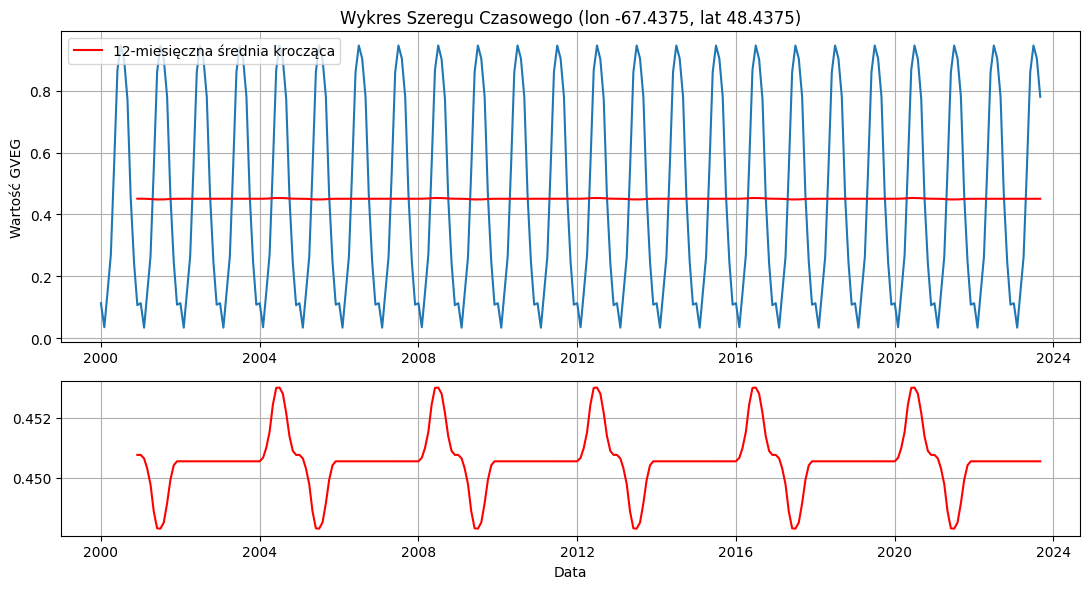

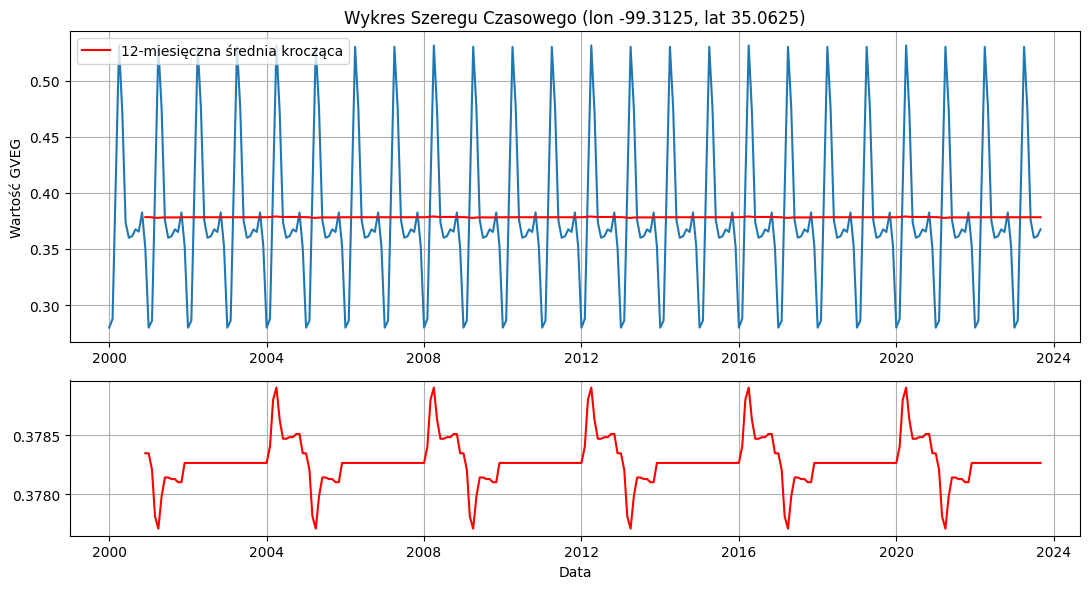

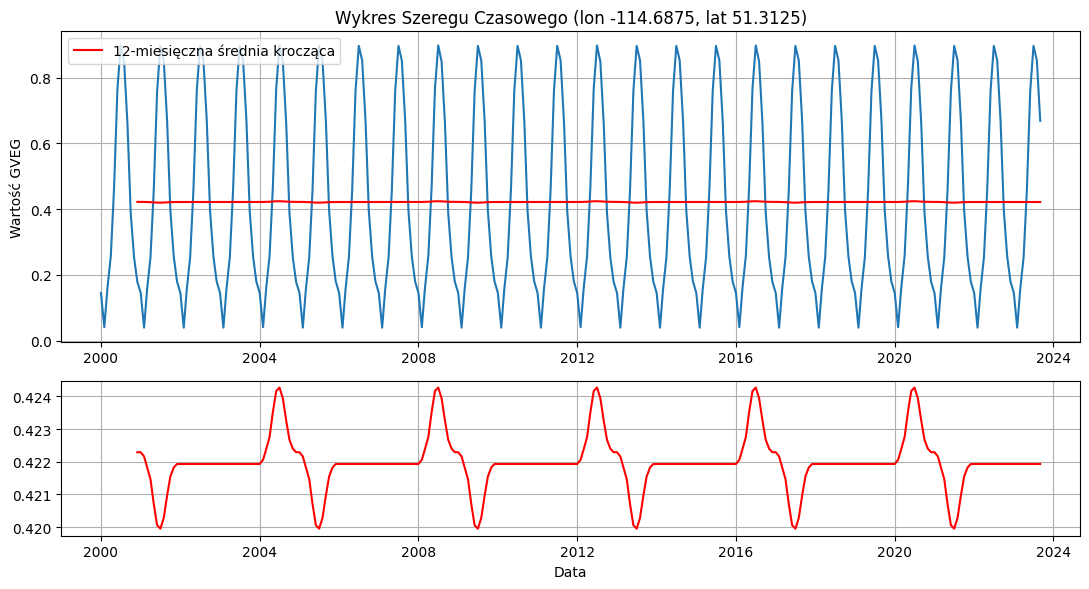

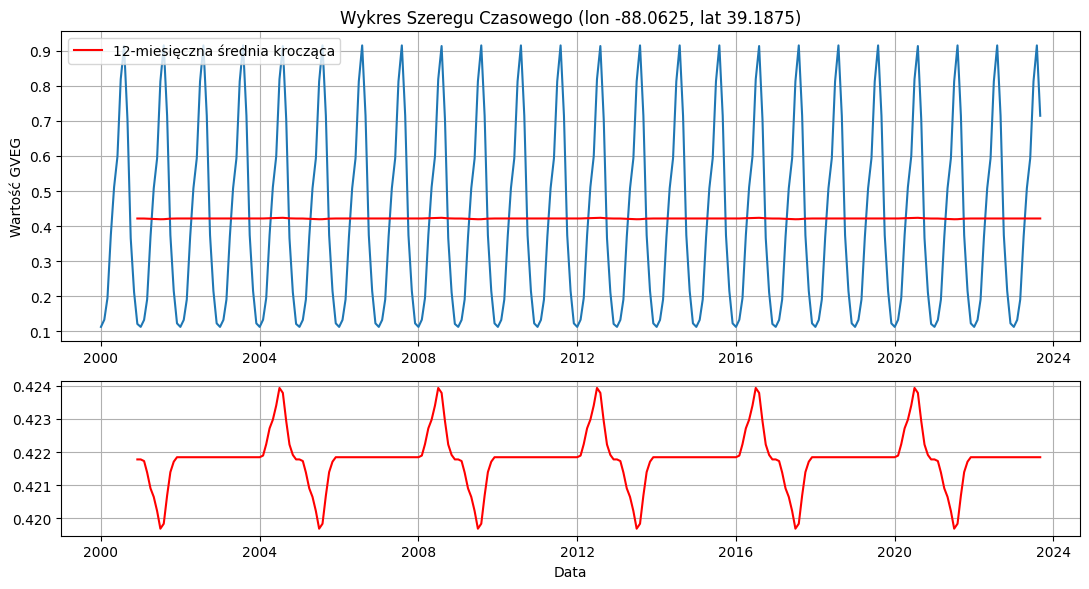

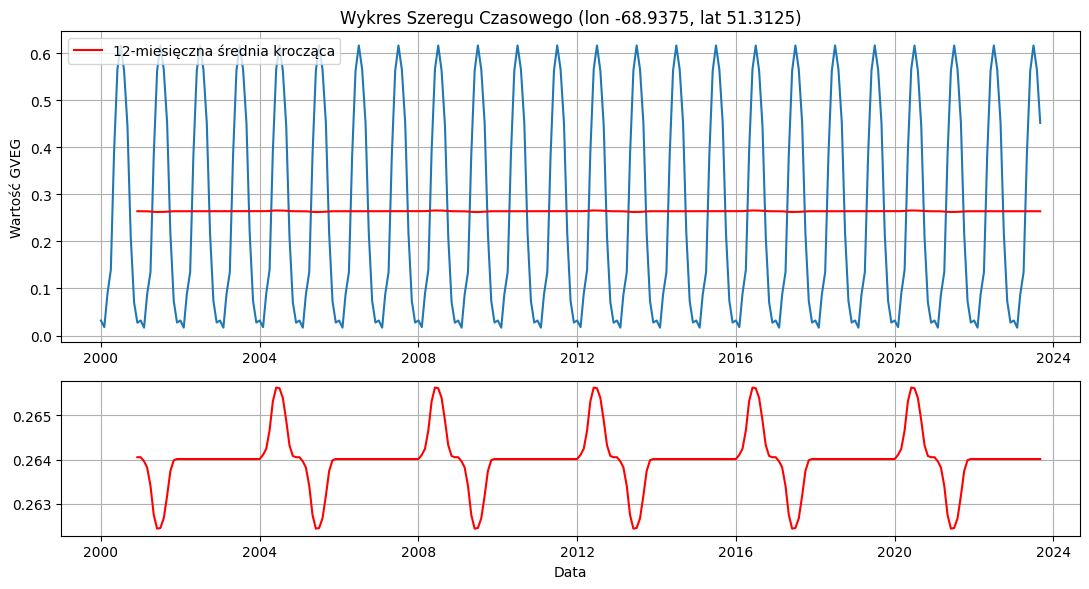

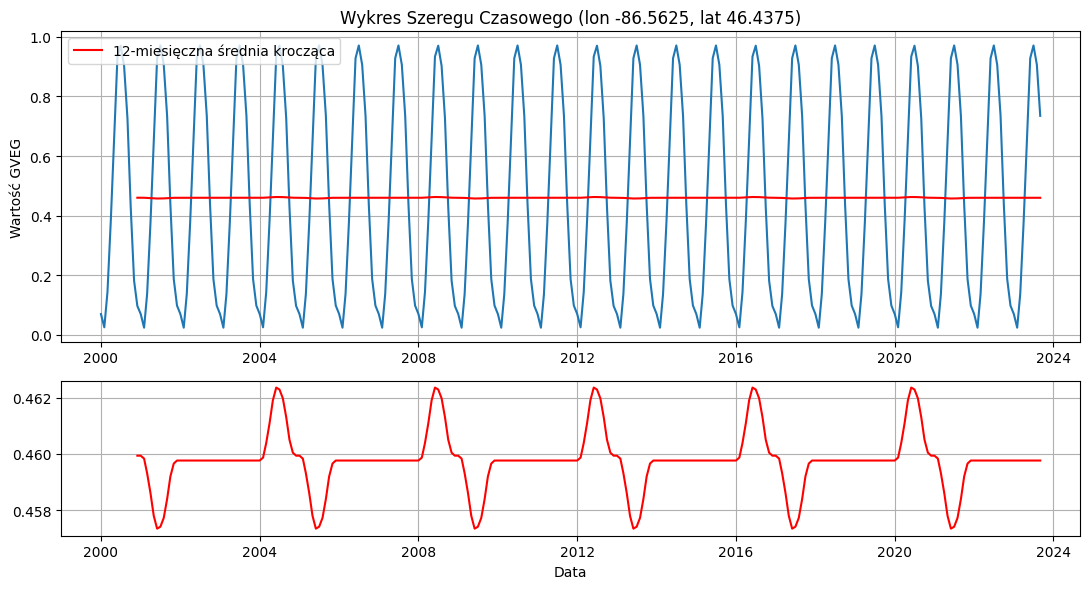

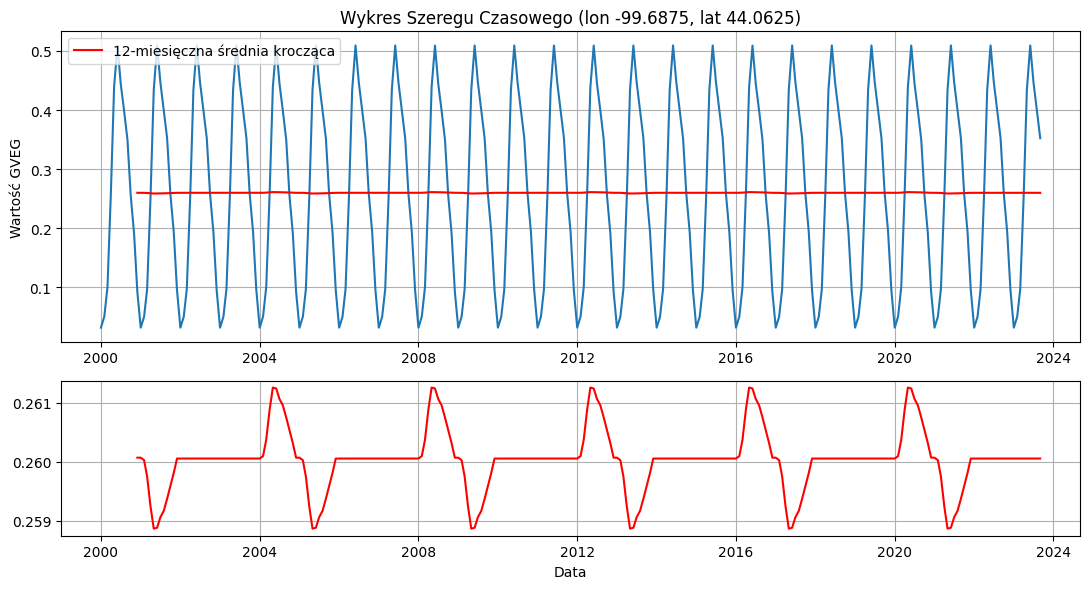

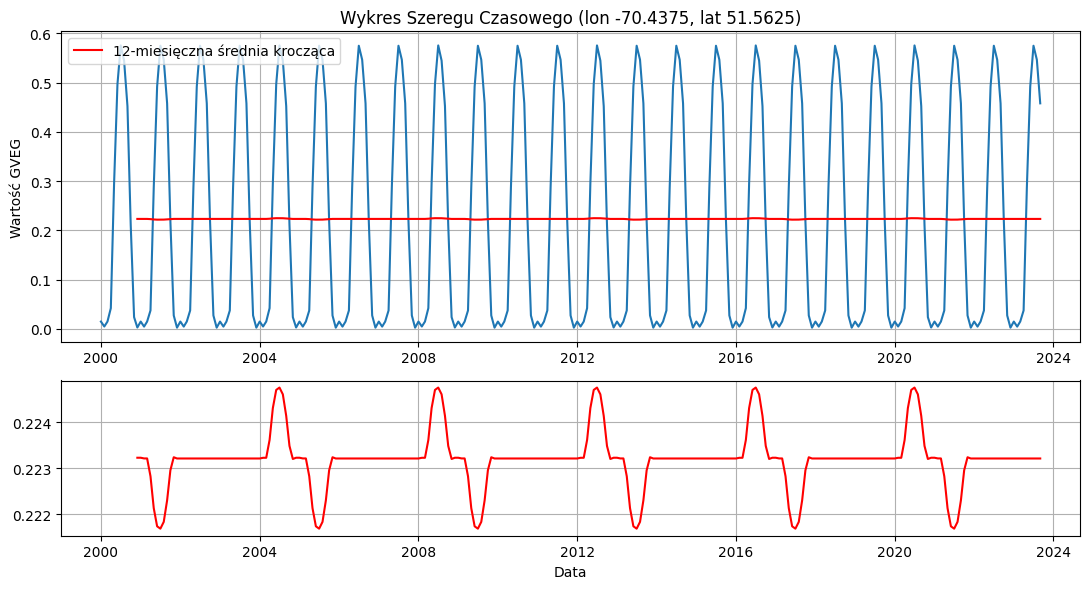

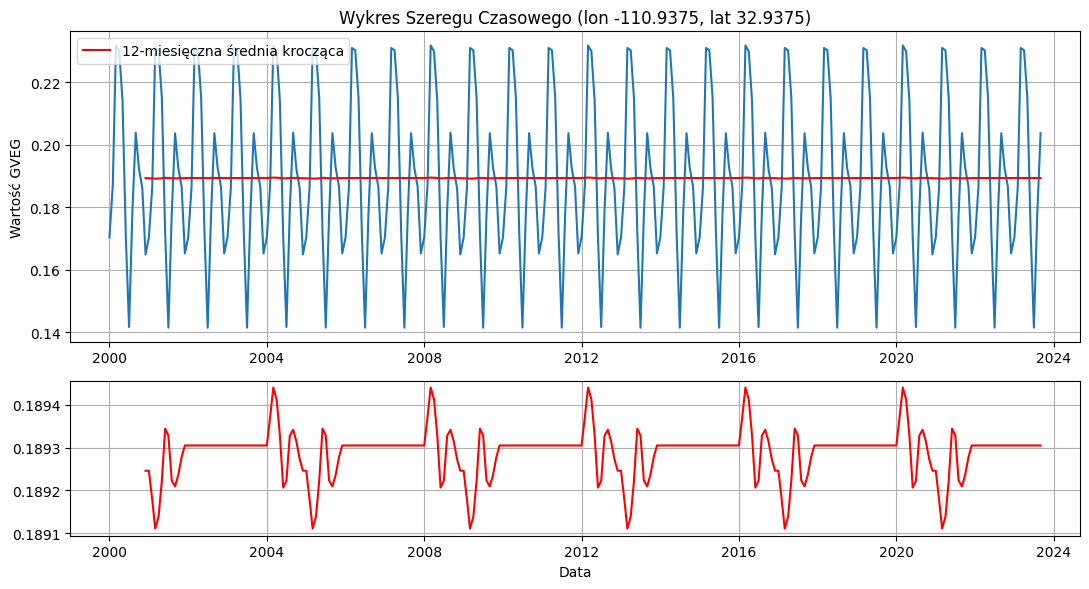

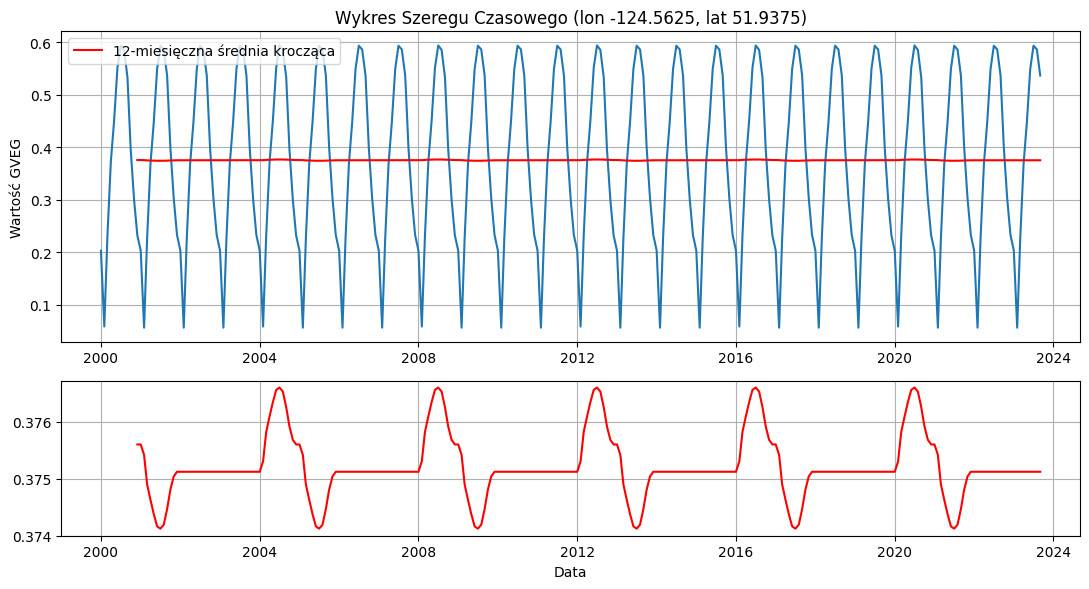

In [120]:
# sprawdzenie szeregu czasowego dla wylosowanych współrzędnych
for i in wylosowane:
  wykres_szeregu(distinct_wsp.iloc[i,0], distinct_wsp.iloc[i,1])

In [108]:
# pustynia mojave i jej "obrzeża" (ograniczenie terenu do współrzednych wytyczających skrajne krańce pustyni)
mojave = distinct_wsp[(distinct_wsp['lon'] >= -116.15) &  (distinct_wsp['lon']  <= -114.95) & (distinct_wsp['lat']  <= 35.45) & (distinct_wsp['lat']  >= 34.7)]

In [109]:
# losujemy 10 współrzednych z zakresu pustyni mojave i jej obrzeży
wylosowane = random.sample(mojave.index.tolist(), 10)

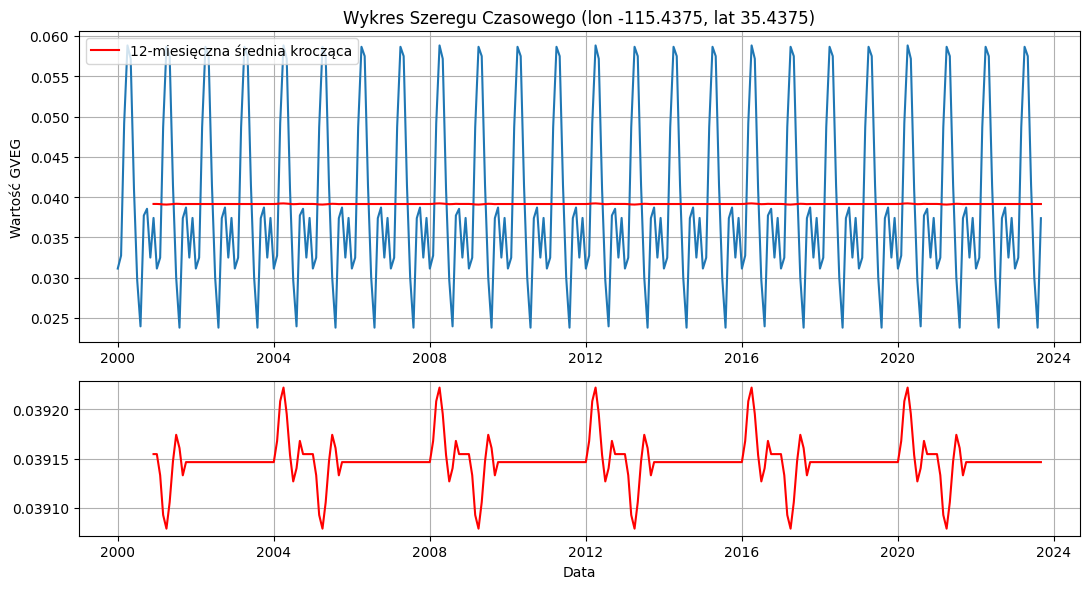

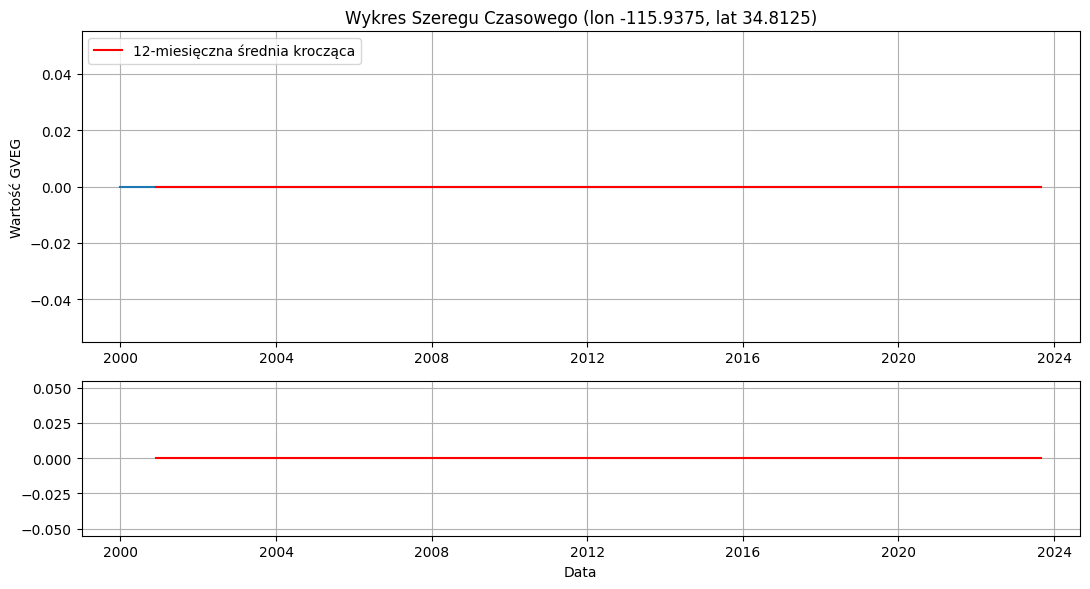

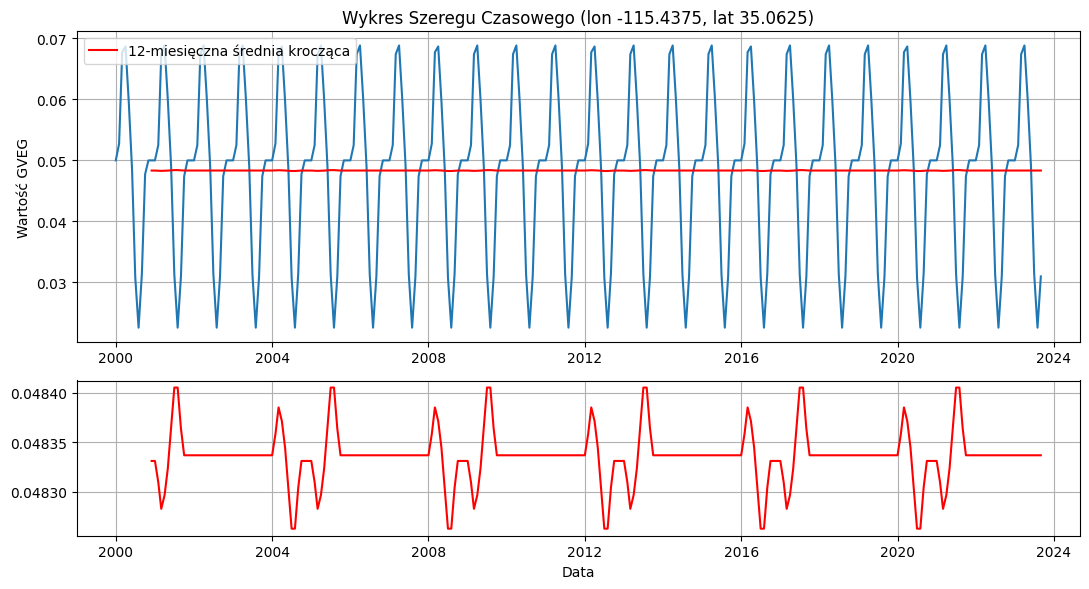

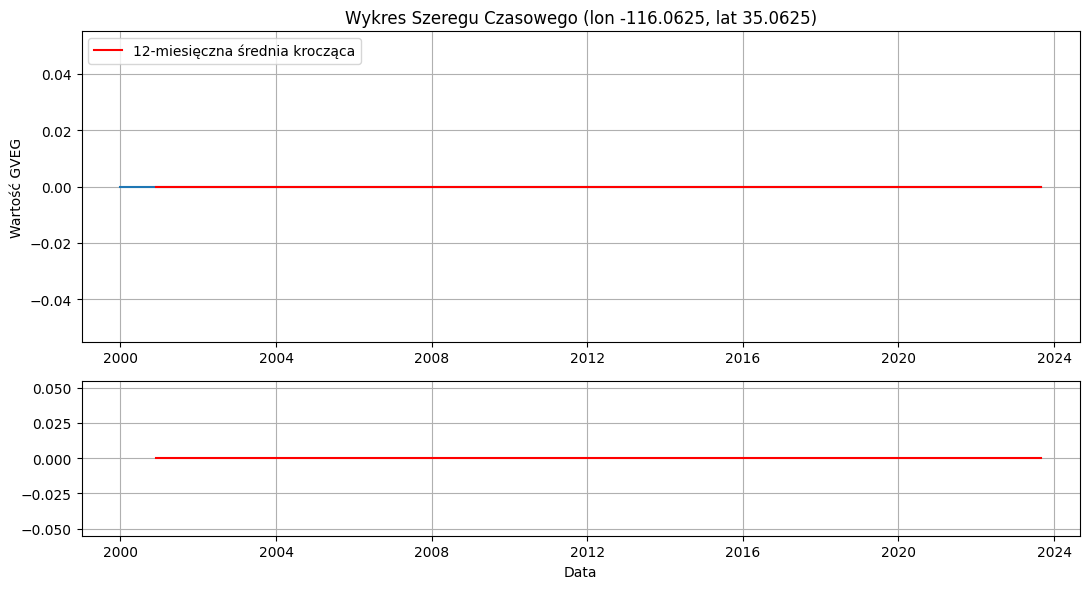

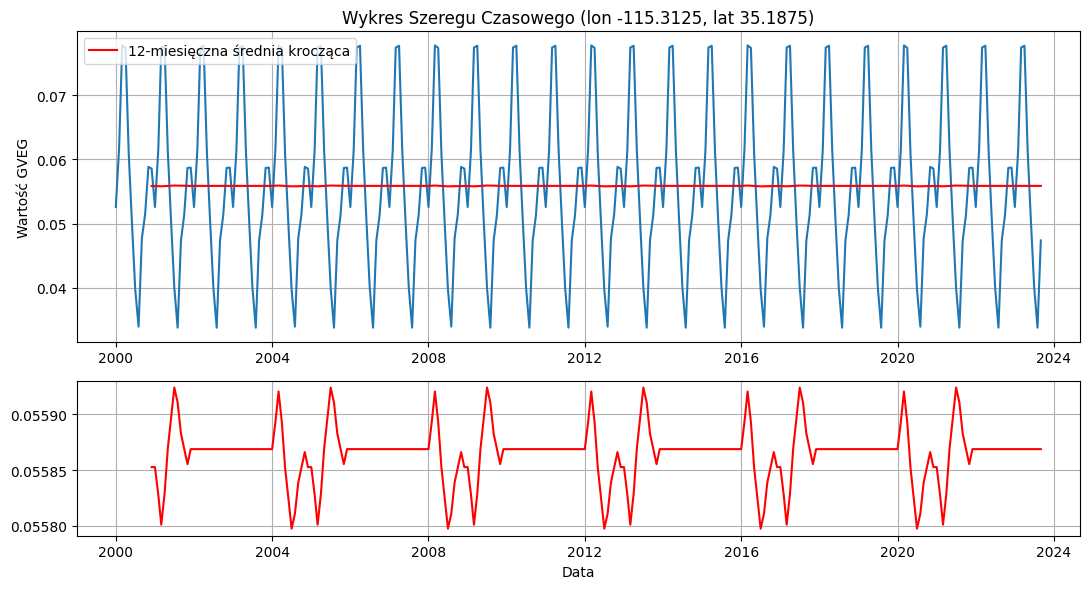

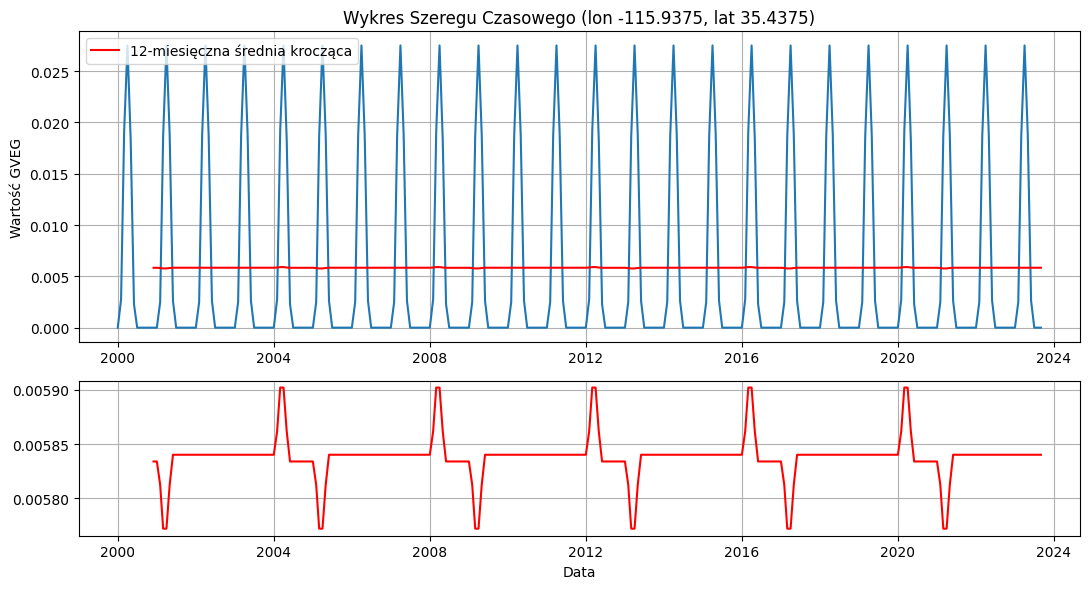

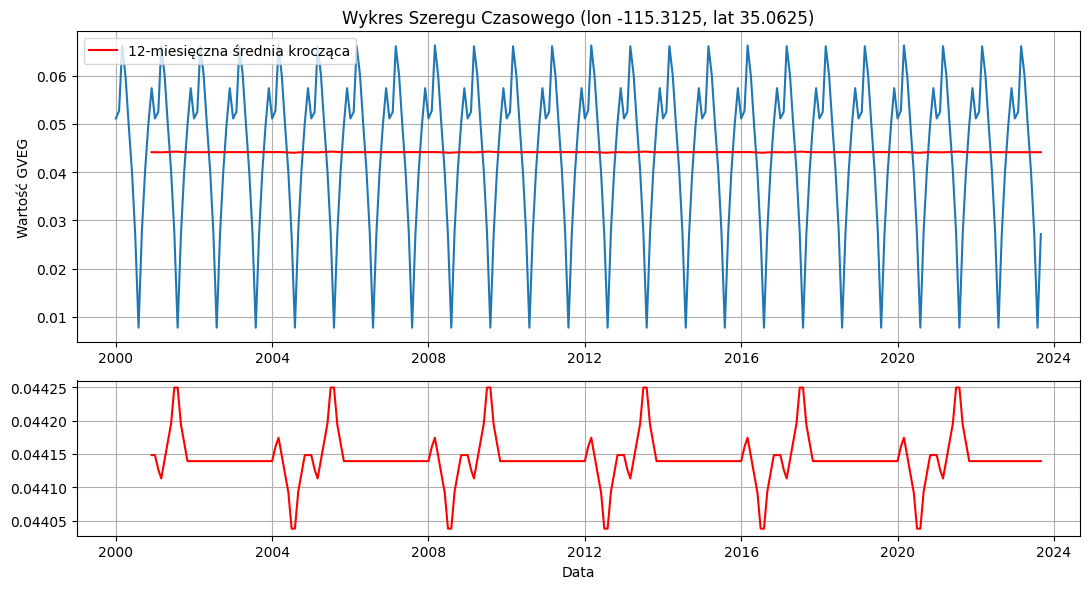

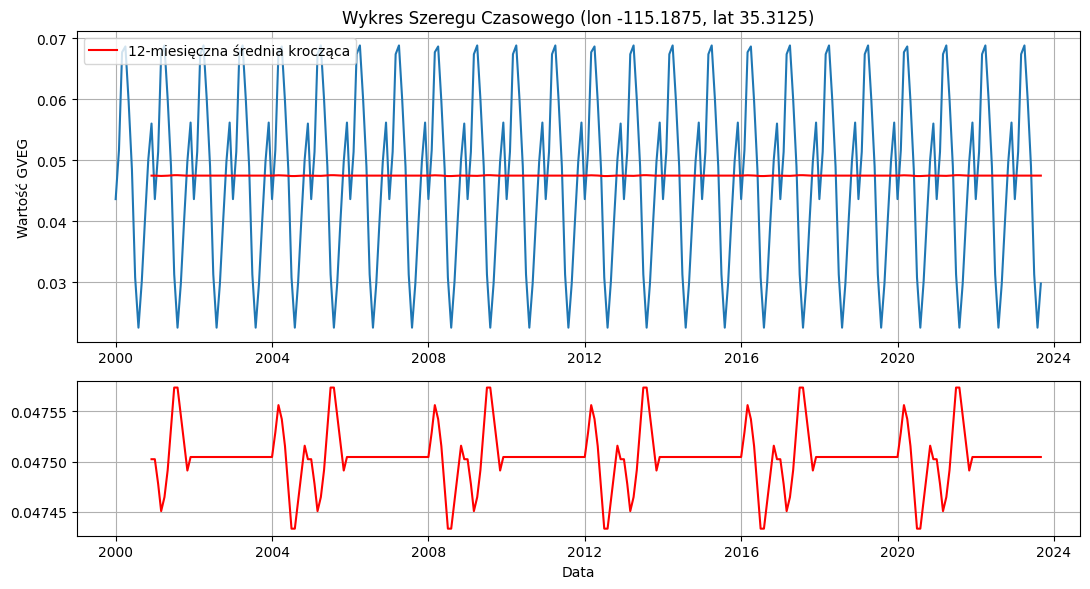

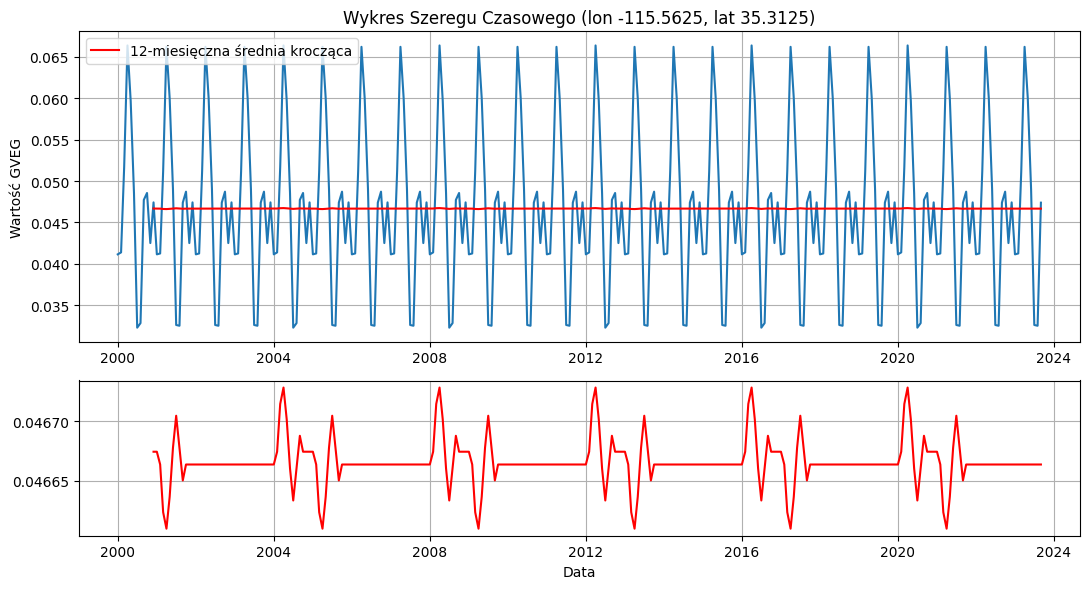

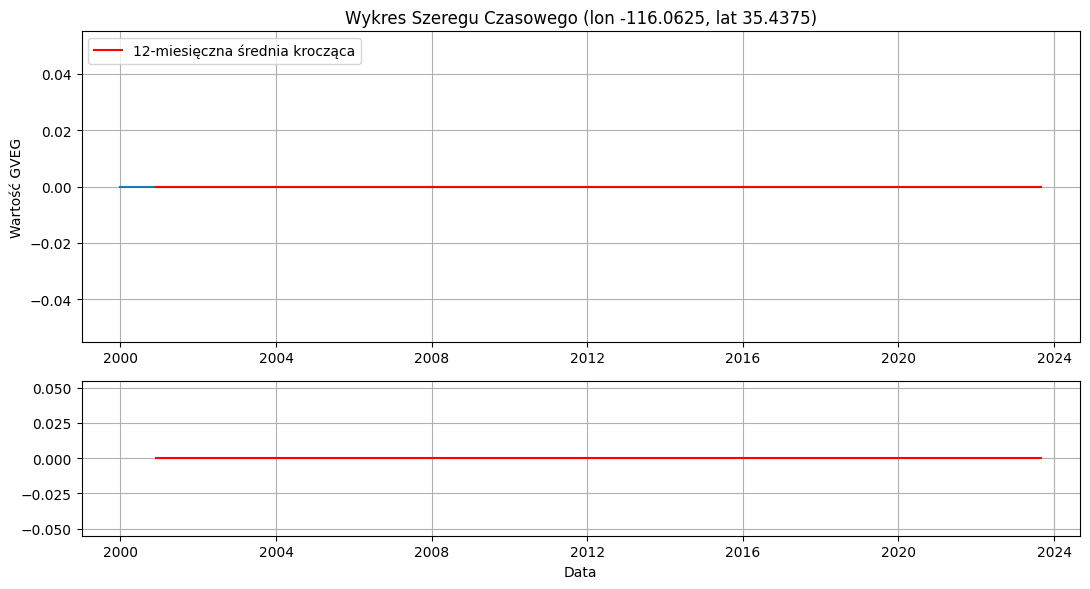

In [110]:
# sprawdzenie szeregu czasowego dla wylosowanych współrzędnych
for i in wylosowane:
  wykres_szeregu(distinct_wsp.iloc[i,0], distinct_wsp.iloc[i,1])

test